Лабораторная работа №2

В моем случае берутся 2 столбика данных: 
    Friends
    Income

income   430 640 610 330 420 290 480 610 840 330 560 450 350 310 380 340 660 450 540 750

friends   5   7   10  4   2   6   9   5   10  3   8   4   7   4   1   5   8   9   6   4

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import t, f
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

print("Загрузка данных")
try:
    df = pd.read_csv('../students_simple.csv')
    print(f"Размер данных: {df.shape[0]} строк, {df.shape[1]} столбцов")
except FileNotFoundError:
    print("Ошибка: Файл students_simple.csv не найден!")

# Столбцы анализа
x = df.iloc[:, 2].values  # доход (income)
y = df.iloc[:, 8].values  # количество друзей (friends)

print(f"\nАнализируемые переменные:")
print(f"  X: Доход (столбец 2)")
print(f"  Y: Количество друзей (столбец 8)")
print(f" Размер выборки: {len(x)} наблюдений")

## 1. Расчет корреляций

***Фехнера***

$$
K = \frac{
    \sum_{i=1}^{n} 
    [sign(x_i - \overline{x}) = sign(y_i - \overline{y})] - 
    [sign(x_i - \overline{x}) \ne sign(y_i - \overline{y})]
    }{n}
$$


***Пирсона***

$$
    cov = \frac{
        \sum_{i=1}^{n}
            (x_i - \overline{x}) (y_i - \overline{y}) 
    }{n-1}
$$

Для приведения значений в интервал $[-1, 1]$, ковариацию делят на проивзедение стандартных отклонений признаков.
$$
    K = \frac{cov}{S_x S_y}
$$

где $S_x^2$ - выборочная дисперсия,
$$
    S_x^2 = \frac{\sum_{i=1}^{n} (x - \overline{x})^2}{n-1}
$$


***Спирмена***

$$
K = \frac{
    \sum_{i=1}^{n} 
    (R(x_i) - \overline{R(x)}) \cdot (R(y_i) - \overline{R(y)}) 
    }
    {
        \left[
        \left( \sum_{i=1}^{n} (R(x_i) - \overline{R(x)})^2 \right)
        \cdot
        \left( \sum_{i=1}^{n} (R(y_i) - \overline{R(y)})^2 \right)
        \right]^{\frac{1}{2}}
    } =
$$
$$
= 1 - \frac{6}{n (n-1) (n+1)} \sum_{i=1}^{n} \left( R(x_i) - R(y_i)\right)^2
$$

***Кенделла***

$$
K = 1 - \frac{4}{n (n-1)} 
\sum_{i=1}^{n-1} \sum_{j=i+1}^{n}
\left[ [x_i < x_j] \ne [y_i < y_j] \right]
$$


In [ ]:
def fechner_correlation(x, y):
    """
    Корреляция Фехнера основана на сравнении знаков отклонений от среднего
    Формула: K = (число совпадений знаков - число несовпадений) / n
    """
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    sign_x = np.sign(x - x_mean)
    sign_y = np.sign(y - y_mean)
    
    matches = np.sum(sign_x == sign_y)
    mismatches = np.sum(sign_x != sign_y)
    
    K = (matches - mismatches) / len(x)
    return K

print("Расчет корреляций")

# Фехнера
fechner_corr = fechner_correlation(x, y)
print(f"1. Корреляция Фехнера: {fechner_corr:.4f}")

# Пирсона с доверительным интервалом
pearson_corr, pearson_p = stats.pearsonr(x, y)
n = len(x)

# Расчет 95% доверительного интервала для Пирсона
z = np.arctanh(pearson_corr)
se = 1 / np.sqrt(n - 3)
pearson_ci_lower = np.tanh(z - 1.96 * se)
pearson_ci_upper = np.tanh(z + 1.96 * se)

print(f"2. Корреляция Пирсона: {pearson_corr:.4f}")
print(f"   p-value: {pearson_p:.4f}")
print(f"   95% доверительный интервал: [{pearson_ci_lower:.4f}, {pearson_ci_upper:.4f}]")

# Спирмена
spearman_corr, spearman_p = stats.spearmanr(x, y)
print(f"3. Корреляция Спирмена: {spearman_corr:.4f}")

# Кенделла
kendall_corr, kendall_p = stats.kendalltau(x, y)
print(f"4. Корреляция Кенделла: {kendall_corr:.4f}")


Вывод подсчитанныз результатов:
Расчет корреляций
1. Корреляция Фехнера: 0.4000
2. Корреляция Пирсона: 0.4975
   p-value: 0.0256
   95% доверительный интервал: [0.0705, 0.7704]
3. Корреляция Спирмена: 0.5156
4. Корреляция Кенделла: 0.3693

## 2. Визуализация
1. Гистограммы
2. График рассеяния (scatter plot)
   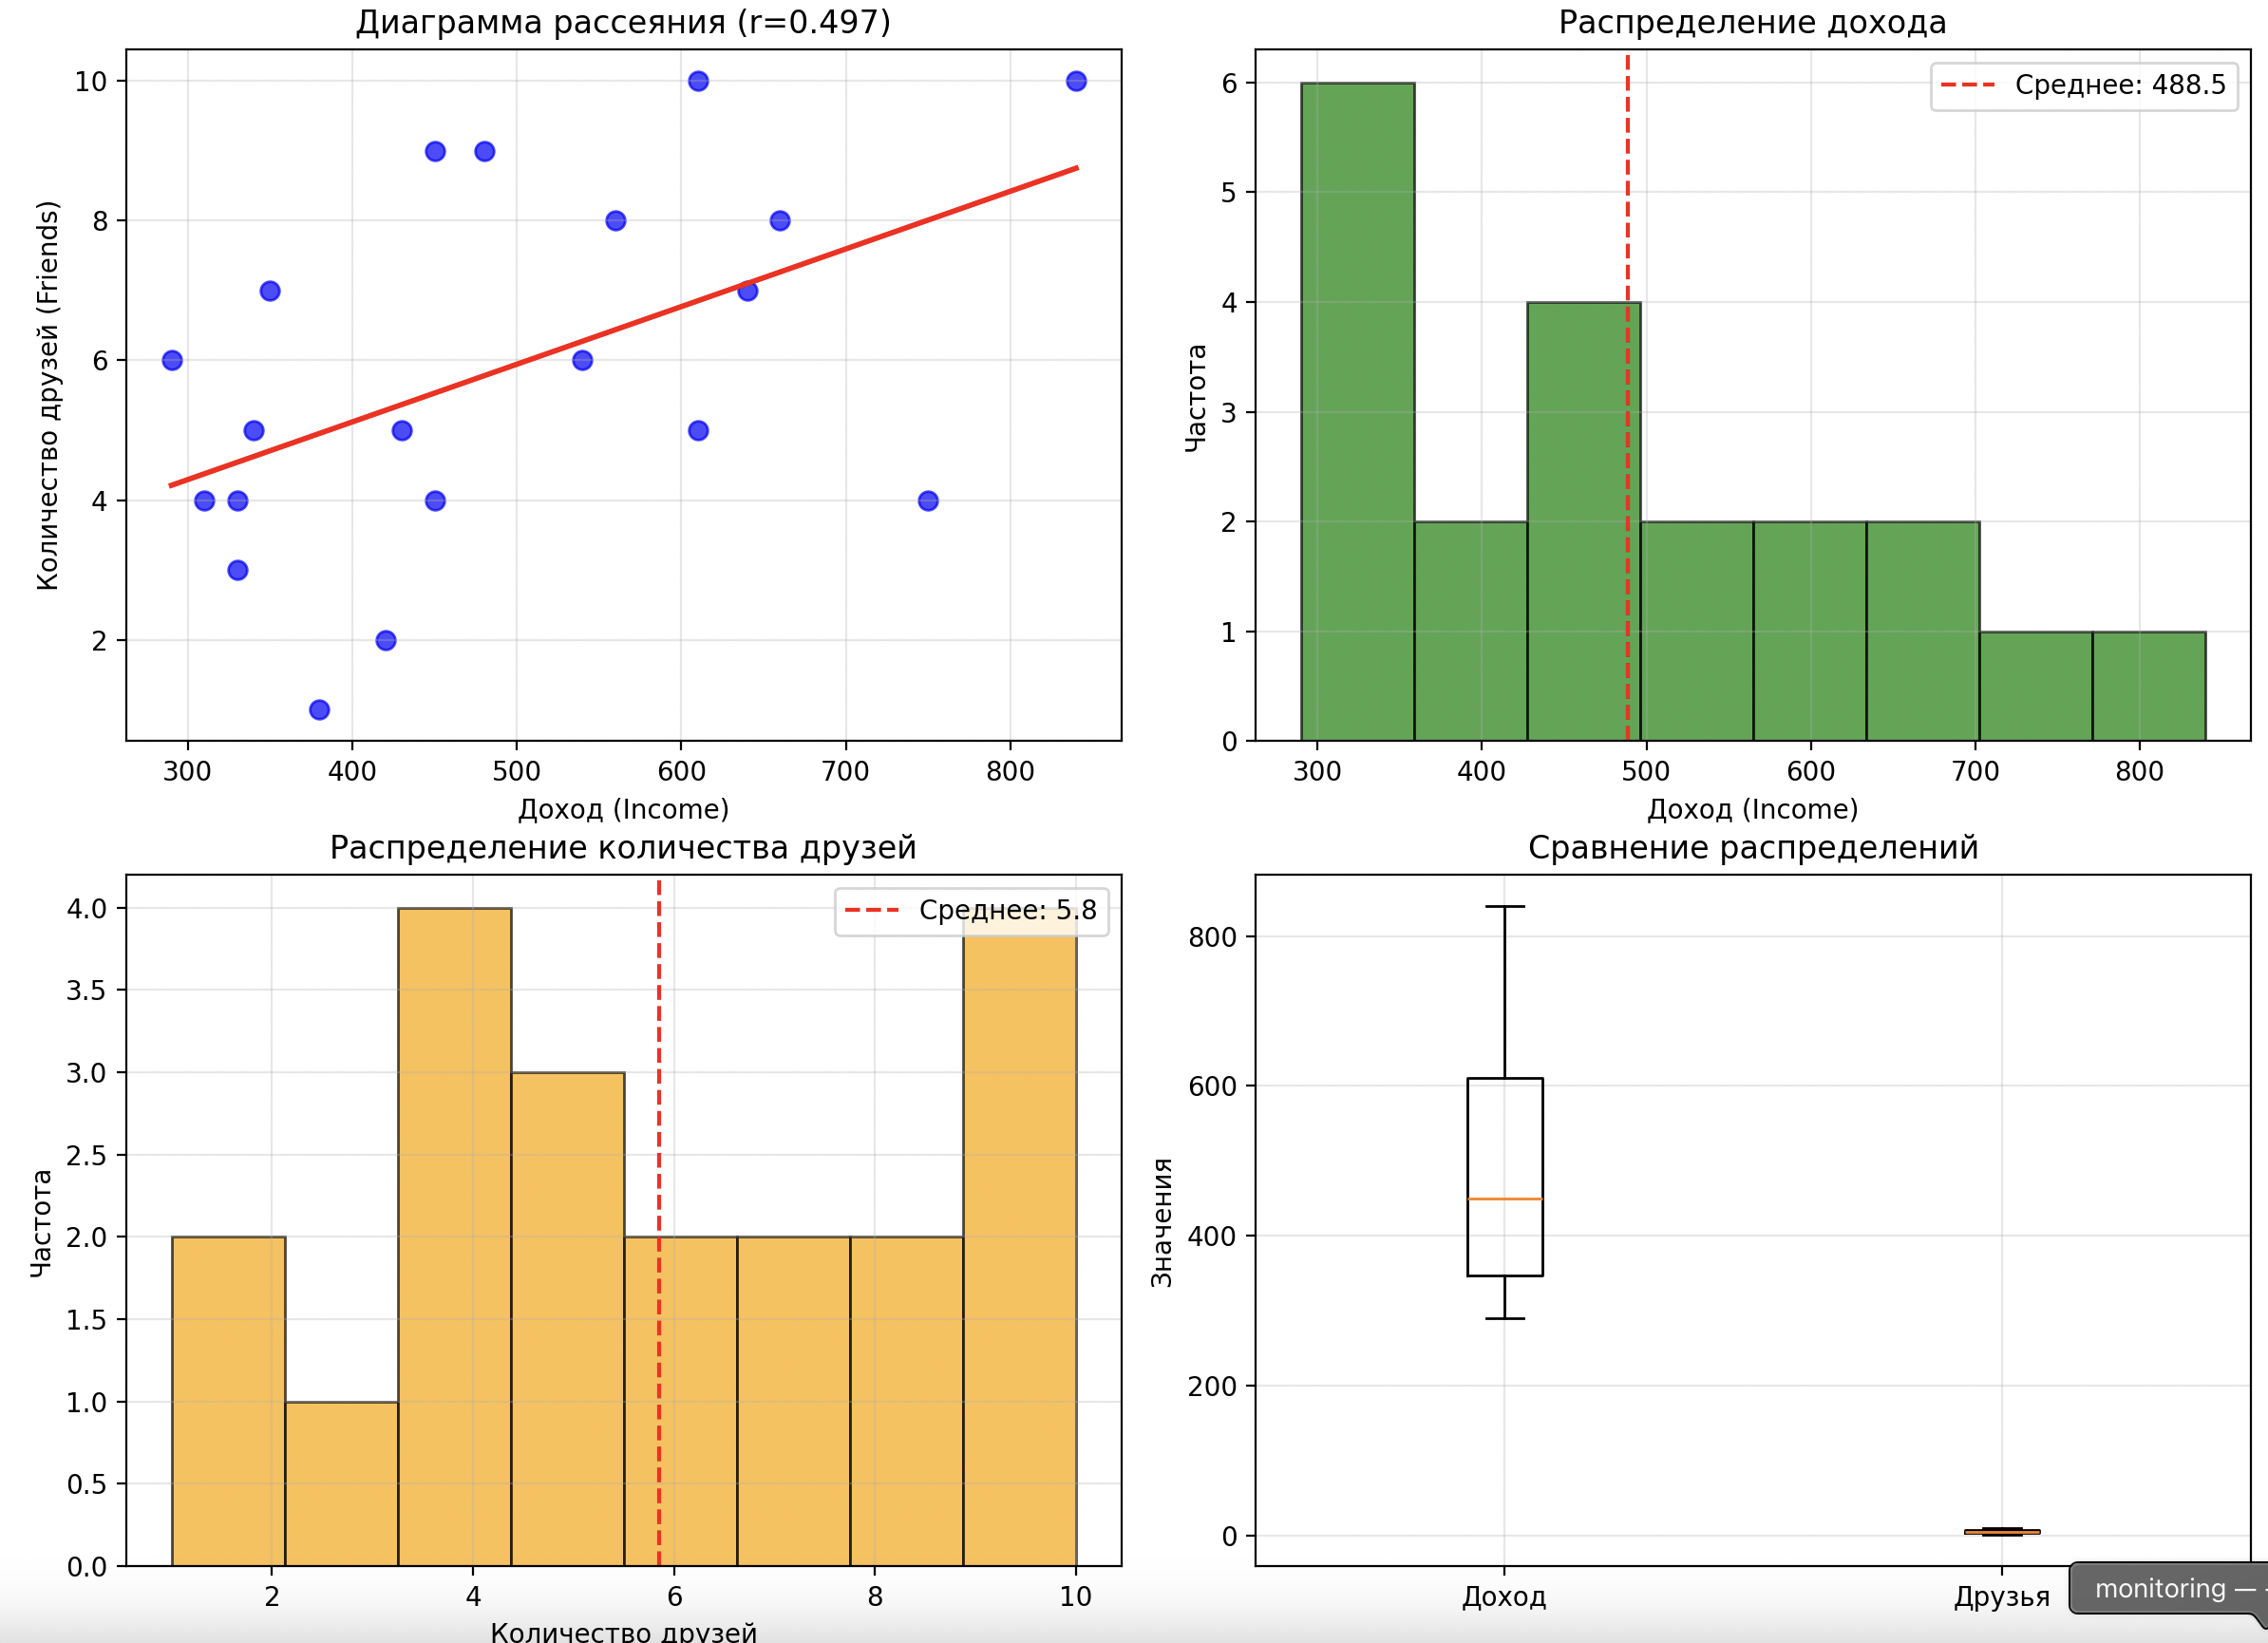

In [ ]:
print("Визуализация данных")

# Создание комплексной визуализации
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Диаграмма рассеяния с линией тренда
axes[0, 0].scatter(x, y, alpha=0.7, color='blue', s=50)
# Добавление линии тренда
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
x_line = np.linspace(min(x), max(x), 100)
axes[0, 0].plot(x_line, p(x_line), "r-", linewidth=2)
axes[0, 0].set_xlabel('Доход (Income)')
axes[0, 0].set_ylabel('Количество друзей (Friends)')
axes[0, 0].set_title(f'Диаграмма рассеяния (r={pearson_corr:.3f})')
axes[0, 0].grid(True, alpha=0.3)

# Гистограмма распределения дохода
axes[0, 1].hist(x, bins=8, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].axvline(np.mean(x), color='red', linestyle='--', 
                  label=f'Среднее: {np.mean(x):.1f}')
axes[0, 1].set_xlabel('Доход (Income)')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].set_title('Распределение дохода')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Гистограмма распределения количества друзей
axes[1, 0].hist(y, bins=8, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].axvline(np.mean(y), color='red', linestyle='--', 
                  label=f'Среднее: {np.mean(y):.1f}')
axes[1, 0].set_xlabel('Количество друзей')
axes[1, 0].set_ylabel('Частота')
axes[1, 0].set_title('Распределение количества друзей')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Box plot для сравнения распределений
axes[1, 1].boxplot([x, y], labels=['Доход', 'Друзья'])
axes[1, 1].set_ylabel('Значения')
axes[1, 1].set_title('Сравнение распределений')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Вывод статистик
print("\nСтатистики данных:")
print(f"Доход (Income):")
print(f"  • Среднее: {np.mean(x):.1f}")
print(f"  • Стандартное отклонение: {np.std(x):.1f}")
print(f"  • Минимум: {np.min(x)}")
print(f"  • Максимум: {np.max(x)}")
print(f"  • Медиана: {np.median(x):.1f}")

print(f"Количество друзей (Friends):")
print(f"  • Среднее: {np.mean(y):.1f}")
print(f"  • Стандартное отклонение: {np.std(y):.1f}")
print(f"  • Минимум: {np.min(y)}")
print(f"  • Максимум: {np.max(y)}")
print(f"  • Медиана: {np.median(y):.1f}")

## 3. Уравнение регрессии
Построение регрессионных моделей:

1. линейная, $y=w_1 x + w_0$
2. квадратичная, $y = w_2 x^2 + w_1 x + w_0$
3. гиперболическая, $y = \frac{w_1}{x} + w_0$ 
4. показательная, $y = w_1^x \cdot w_0$
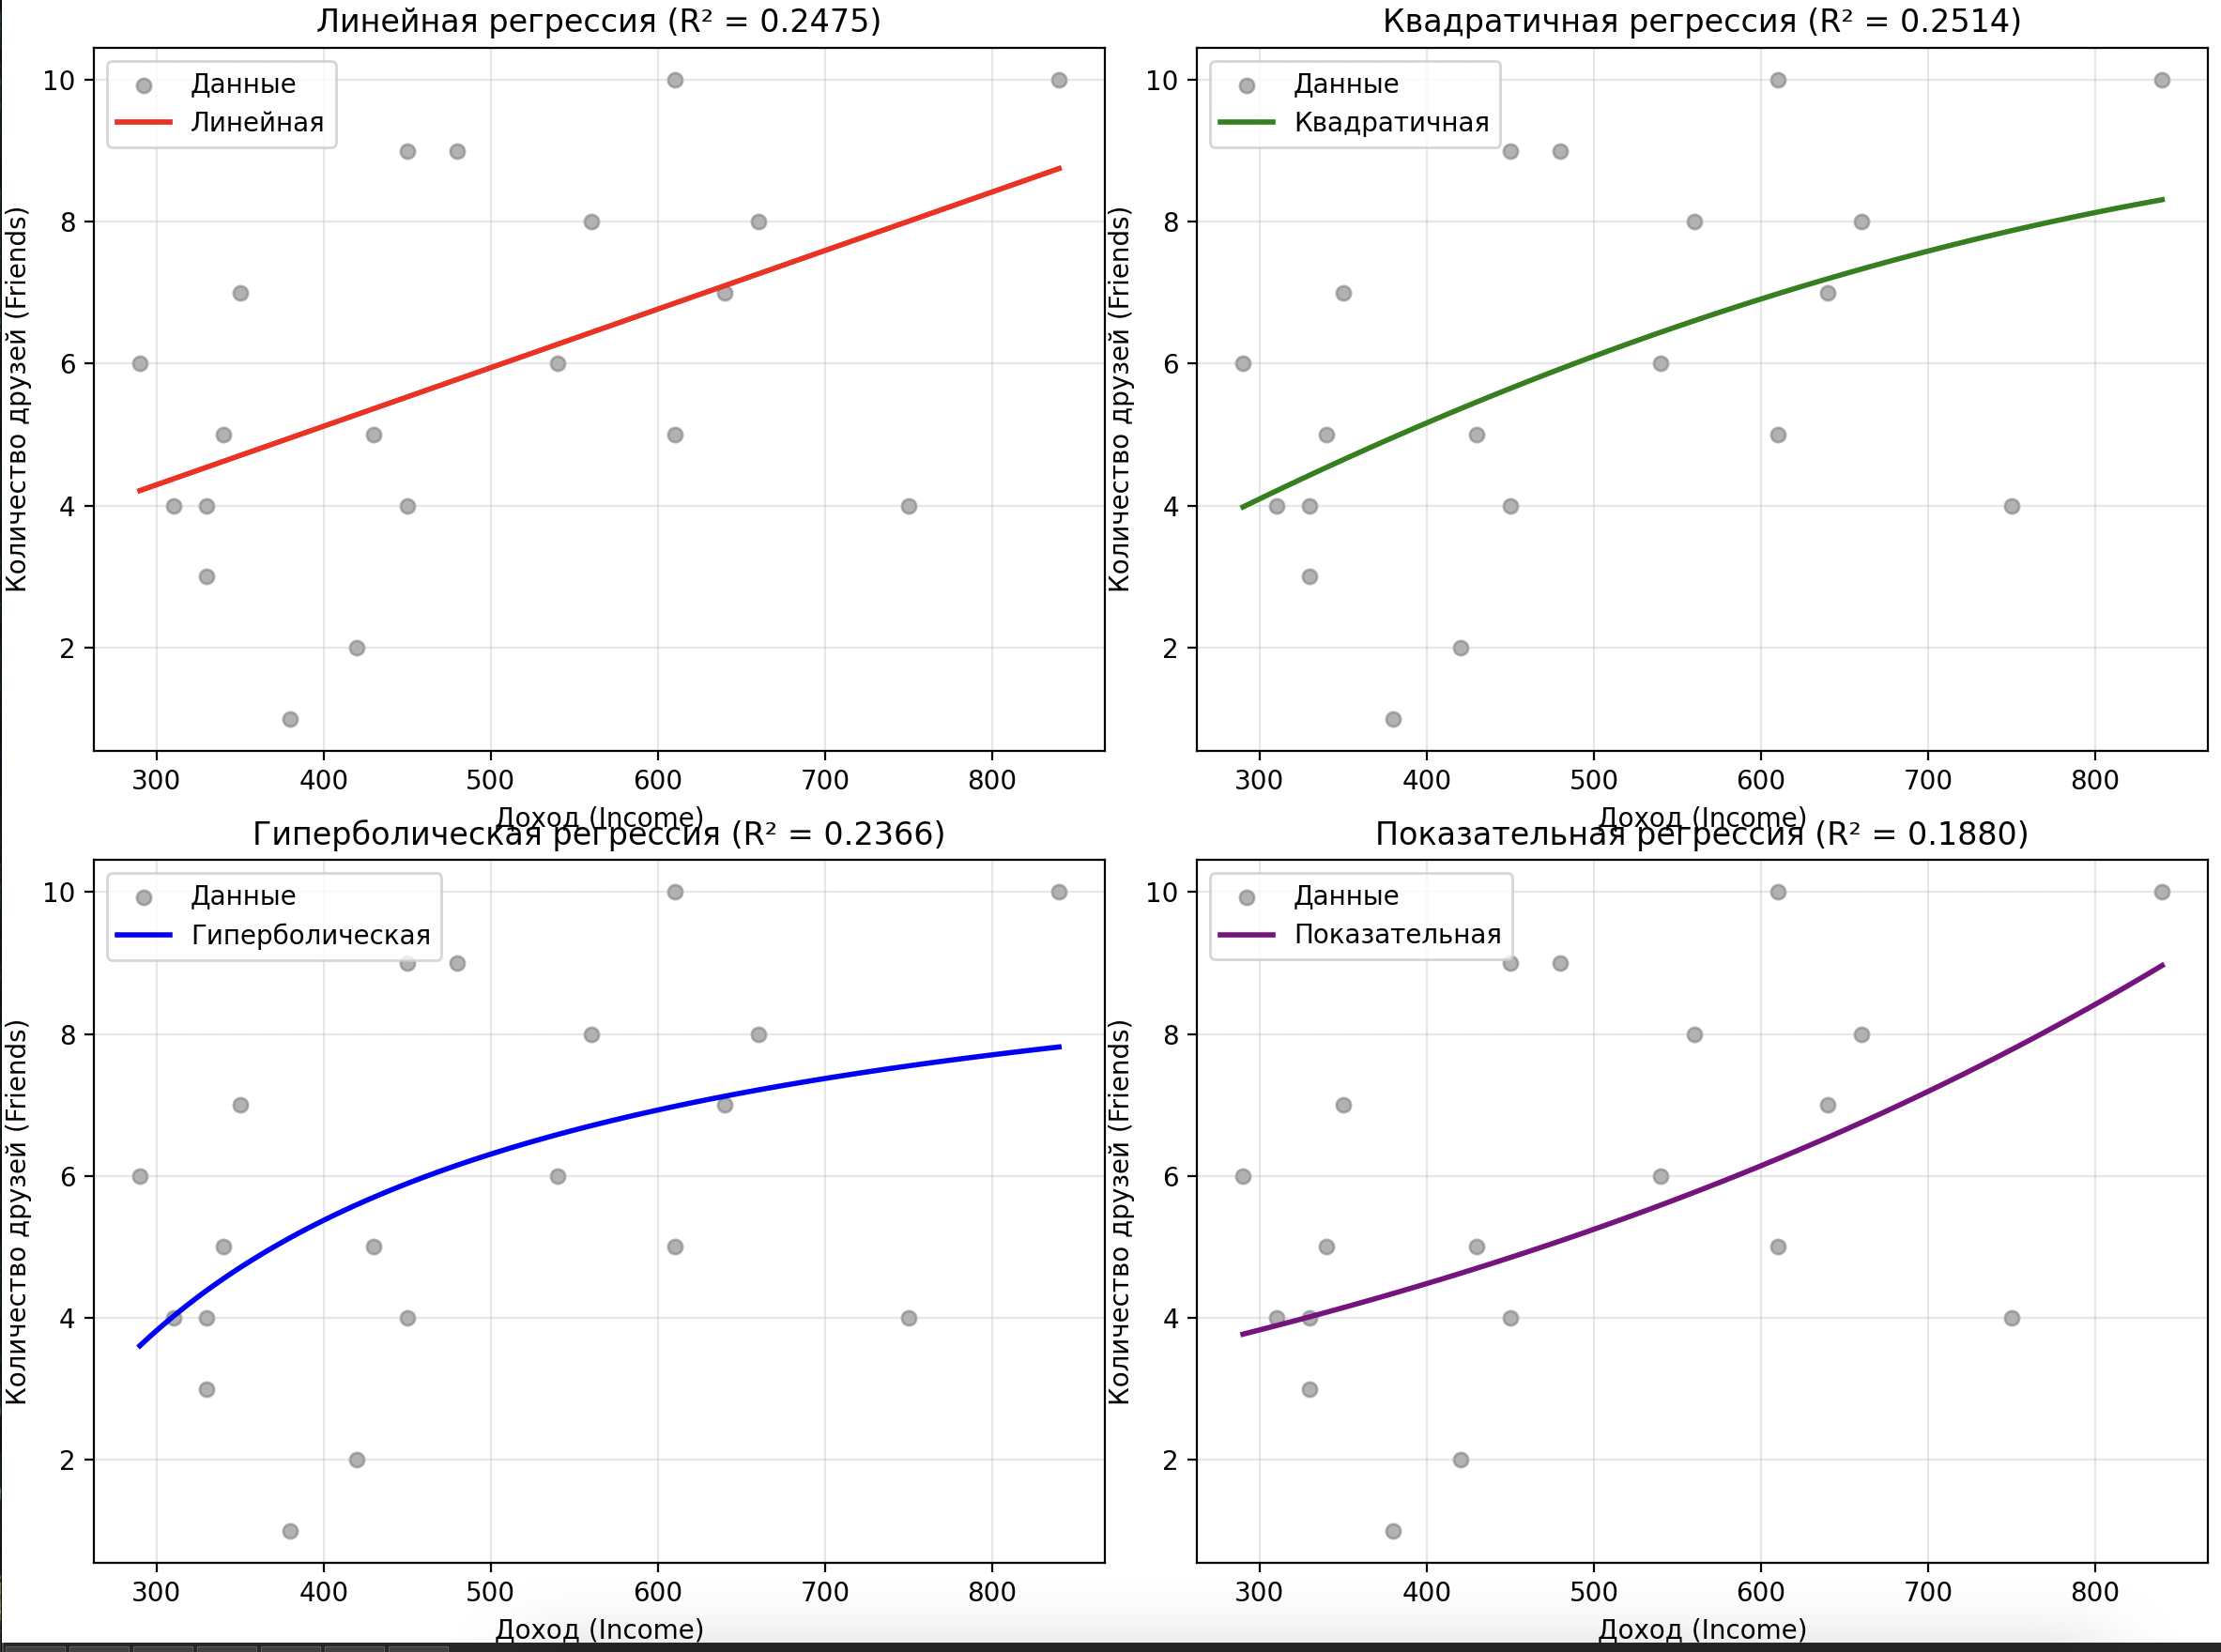

Статистики данных:
Доход (Income):

  • Среднее: 488.5

  • Стандартное отклонение: 152.8

  • Минимум: 290

  • Максимум: 840

  • Медиана: 450.0

Количество друзей (Friends):

  • Среднее: 5.8

  • Стандартное отклонение: 2.5

  • Минимум: 1

  • Максимум: 10

  • Медиана: 5.5

Построение регрессионных моделей
1. Линейная регрессия:

   Уравнение: y = 0.0083 * x + 1.8192

   R² = 0.2475

2. КВАДРАТИЧНАЯ РЕГРЕССИЯ:

   Уравнение: y = -0.0000 * x² + 0.0153 * x + 0.0917

   R² = 0.2514

3. ГИПЕРБОЛИЧЕСКАЯ РЕГРЕССИЯ:

   Уравнение: y = -1864.7482 / x + 10.0379

   R² = 0.2366

4. Показательная регрессия:

   Уравнение: y = 2.3886 * 1.0016^x

   R² = 0.1880

In [ ]:
# Класс для линейной регрессии методом наименьших квадратов
class SimpleLinearRegression:
    def __init__(self):
        self.w0 = 0 
        self.w1 = 0  # коэффициент при x
        
    def fit(self, X, y):
        """Метод наименьших квадратов для линейной регрессии"""
        X = X.flatten()
        x_mean = np.mean(X)
        y_mean = np.mean(y)
        
        # Вычисление коэффициентов по формулам МНК
        numerator = np.sum((X - x_mean) * (y - y_mean))
        denominator = np.sum((X - x_mean) ** 2)
        
        self.w1 = numerator / denominator
        self.w0 = y_mean - self.w1 * x_mean
        
    def predict(self, X):
        return self.w0 + self.w1 * X

print("Построение регрессионных моделей")

X = x.reshape(-1, 1)
x_range = np.linspace(min(x), max(x), 100).reshape(-1, 1)
models_results = []

# Линейная регрессия: y = w₁x + w₀
linear_model = SimpleLinearRegression()
linear_model.fit(x, y)
y_linear_pred = linear_model.predict(x)
r2_linear = 1 - np.sum((y - y_linear_pred)**2) / np.sum((y - np.mean(y))**2)

print("1. Линейная регрессия:")
print(f"   Уравнение: y = {linear_model.w1:.4f} * x + {linear_model.w0:.4f}")
print(f"   R² = {r2_linear:.4f}")

models_results.append({
    'name': 'Линейная',
    'r2': r2_linear,
    'k': 2,  # количество параметров
    'equation': f"y = {linear_model.w1:.4f} * x + {linear_model.w0:.4f}",
    'y_range': linear_model.predict(x_range.flatten())
})

# Квадратичная регрессия: y = w₂x² + w₁x + w₀
try:
    poly2 = PolynomialFeatures(degree=2)
    X_poly2 = poly2.fit_transform(X)
    quadratic_model = LinearRegression()
    quadratic_model.fit(X_poly2, y)
    y_quadratic_pred = quadratic_model.predict(X_poly2)
    r2_quadratic = r2_score(y, y_quadratic_pred)
    
    print("2. КВАДРАТИЧНАЯ РЕГРЕССИЯ:")
    print(f"   Уравнение: y = {quadratic_model.coef_[2]:.4f} * x² + {quadratic_model.coef_[1]:.4f} * x + {quadratic_model.intercept_:.4f}")
    print(f"   R² = {r2_quadratic:.4f}")
    
    models_results.append({
        'name': 'Квадратичная',
        'r2': r2_quadratic,
        'k': 3,
        'equation': f"y = {quadratic_model.coef_[2]:.4f} * x² + {quadratic_model.coef_[1]:.4f} * x + {quadratic_model.intercept_:.4f}",
        'y_range': quadratic_model.predict(poly2.transform(x_range))
    })
except Exception as e:
    print(f"2. Квадратичная регрессия: не удалось построить ({str(e)})")

# Гиперболическая регрессия: y = w₁/x + w₀
X_hyper = 1 / x
hyper_model = SimpleLinearRegression()
hyper_model.fit(X_hyper, y)
y_hyperbolic_pred = hyper_model.predict(X_hyper)
r2_hyperbolic = 1 - np.sum((y - y_hyperbolic_pred)**2) / np.sum((y - np.mean(y))**2)

print("3. ГИПЕРБОЛИЧЕСКАЯ РЕГРЕССИЯ:")
print(f"   Уравнение: y = {hyper_model.w1:.4f} / x + {hyper_model.w0:.4f}")
print(f"   R² = {r2_hyperbolic:.4f}")

models_results.append({
    'name': 'Гиперболическая',
    'r2': r2_hyperbolic,
    'k': 2,
    'equation': f"y = {hyper_model.w1:.4f} / x + {hyper_model.w0:.4f}",
    'y_range': hyper_model.w0 + hyper_model.w1 / x_range.flatten()
})

# Показательная регрессия: y = w₀ * w₁^x
# Преобразование: ln(y) = x*ln(w₁) + ln(w₀)
y_positive = np.where(y > 0, y, 0.1)  # избегаем log(0)
y_log = np.log(y_positive)
exp_model = SimpleLinearRegression()
exp_model.fit(x, y_log)
w1_exp = np.exp(exp_model.w1)  # преобразование обратно
w0_exp = np.exp(exp_model.w0)
y_exponential_pred = w0_exp * (w1_exp ** x)
r2_exponential = 1 - np.sum((y - y_exponential_pred)**2) / np.sum((y - np.mean(y))**2)

print("4. Показательная регрессия:")
print(f"   Уравнение: y = {w0_exp:.4f} * {w1_exp:.4f}^x")
print(f"   R² = {r2_exponential:.4f}")

models_results.append({
    'name': 'Показательная',
    'r2': r2_exponential,
    'k': 2,
    'equation': f"y = {w0_exp:.4f} * {w1_exp:.4f}^x",
    'y_range': w0_exp * (w1_exp ** x_range.flatten())
})


Визуализация регрессионных моделей
Сравнение регрессионных моделей
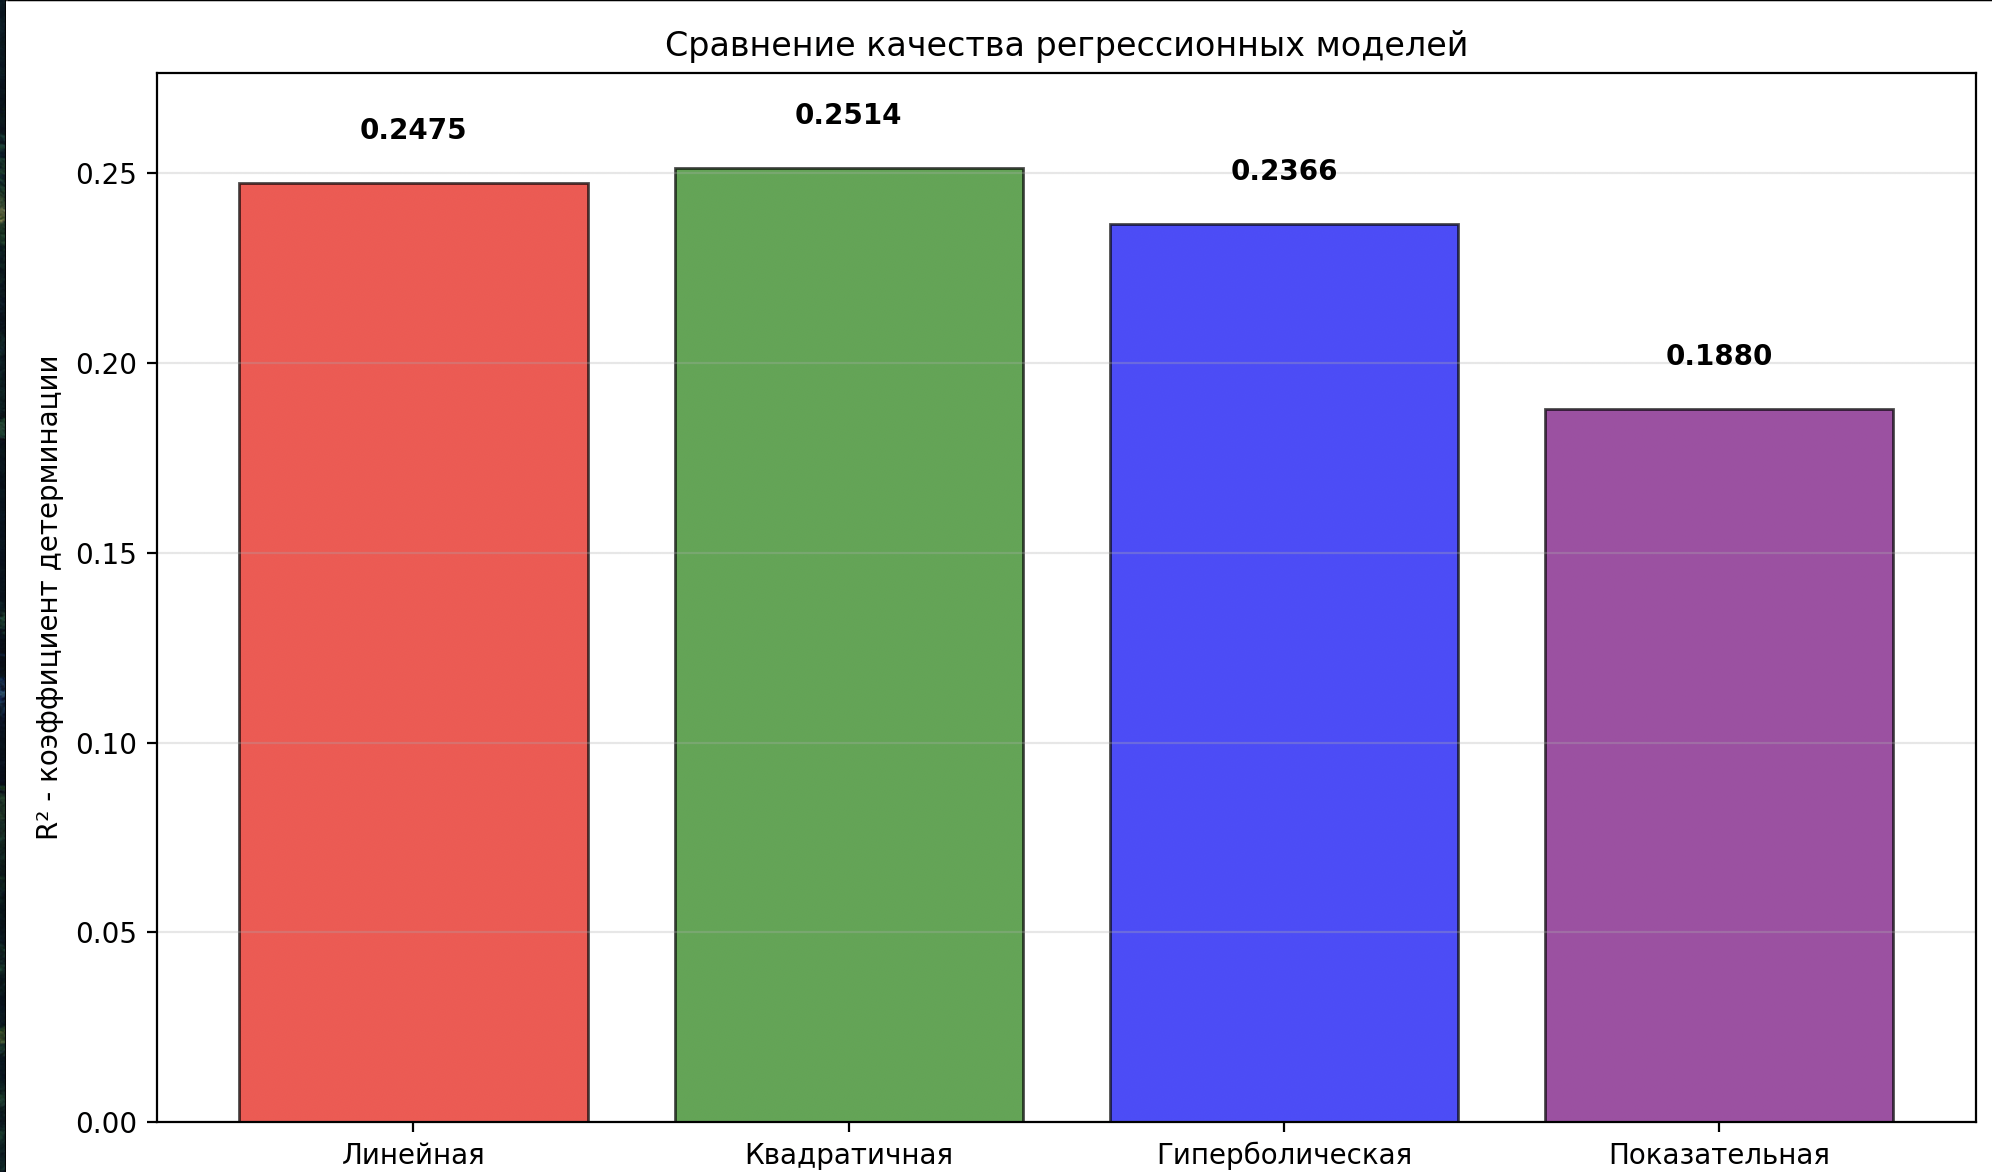

In [ ]:
print("Визуализация регрессионных моделей")

# Графики всех регрессионных моделей
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
colors = ['red', 'green', 'blue', 'purple']

for i, model in enumerate(models_results):
    row, col = i // 2, i % 2
    axes[row, col].scatter(x, y, alpha=0.6, color='gray', s=30, label='Данные')
    axes[row, col].plot(x_range, model['y_range'], color=colors[i], 
                       linewidth=2, label=model['name'])
    axes[row, col].set_xlabel('Доход (Income)')
    axes[row, col].set_ylabel('Количество друзей (Friends)')
    axes[row, col].set_title(f'{model["name"]} регрессия (R² = {model["r2"]:.4f})')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Сравнение качества моделей
plt.figure(figsize=(10, 6))
model_names = [m['name'] for m in models_results]
r2_values = [m['r2'] for m in models_results]

bars = plt.bar(model_names, r2_values, color=['red', 'green', 'blue', 'purple'], 
              alpha=0.7, edgecolor='black')
plt.ylabel('R² - коэффициент детерминации')
plt.title('Сравнение качества регрессионных моделей')
plt.ylim(0, max(r2_values) * 1.1)

for bar, r2 in zip(bars, r2_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{r2:.4f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 4. Проверка уравнения регрессии
Для наилучшего и наихудшего уравнения регрессии проверить соотвествие моедли данным с помощью критерия Фишера

Лучшая модель: Квадратичная
  Уравнение: y = -0.0000 * x² + 0.0153 * x + 0.0917
  Качество (R²): 0.2514
  Объясненная дисперсия: 25.1%

Худшая модель: Показательная
  Уравнение: y = 2.3886 * 1.0016^x
  Качество (R²): 0.1880
  Объясненная дисперсия: 18.8%

In [ ]:
def f_test(r2, n, k, alpha=0.05):
    """
    Проверка значимости регрессии с помощью F-теста
    Формула: F = (R²/(1-R²)) * ((n-k)/(k-1))
    """
    if r2 >= 0.999: r2 = 0.999
    if r2 <= 0.001: r2 = 0.001
        
    F_stat = (r2 / (1 - r2)) * ((n - k) / (k - 1))
    F_critical = f.ppf(1 - alpha, k-1, n-k)
    p_value = 1 - f.cdf(F_stat, k-1, n-k)
    is_significant = F_stat > F_critical
    
    return F_stat, F_critical, p_value, is_significant

print("Проверка значимости моделей (F-ТЕСТ)")

alpha = 0.05
significant_count = 0

for model in models_results:
    F_stat, F_critical, p_value, is_significant = f_test(model['r2'], n, model['k'], alpha)
    status = "ЗНАЧИМА" if is_significant else "НЕ ЗНАЧИМА"
    if is_significant: significant_count += 1
    
    print(f"{model['name']} регрессия: {status}")
    print(f"  F-статистика = {F_stat:.4f}, F-критическое = {F_critical:.4f}")
    print(f"  p-value = {p_value:.4f}")
    print()

# Определение лучшей и худшей модели
best_model = max(models_results, key=lambda x: x['r2'])
worst_model = min(models_results, key=lambda x: x['r2'])

print("Сравнение моделец:")
print(f"Лучшая модель: {best_model['name']}")
print(f"  Уравнение: {best_model['equation']}")
print(f"  Качество (R²): {best_model['r2']:.4f}")
print(f"  Объясненная дисперсия: {best_model['r2']*100:.1f}%")
print()
print(f"Худшая модель: {worst_model['name']}")
print(f"  Уравнение: {worst_model['equation']}")
print(f"  Качество (R²): {worst_model['r2']:.4f}")
print(f"  Объясненная дисперсия: {worst_model['r2']*100:.1f}%")

## 5. Выводы
Сделать вывод по каждому пункту

Выводы

1. Корреляционныц анализ:
   • Корреляция Пирсона: 0.4975 (p-value: 0.0256)
   • Сила связи: умеренная (заметная)
   • Направление: положительная
   • Статистическая значимость: статистически значима

2. Регрессионный анализ:
   • Лучшая модель: Квадратичная (R² = 0.2514)
   • Худшая модель: Показательная (R² = 0.1880)
   • Значимых моделей: 2 из 4
   • Качество лучшей модели: слабое

3. Практические выводы:
   • Обнаружена статистически значимая связь между доходом и количеством друзей
   • не рекомендуется для практического использования
   • С ростом дохода количество друзей имеет тенденцию к увеличению


In [ ]:
print("Выводы")

# Анализ корреляций
print("\n1. Корреляционный анализ:")
print(f"   • Корреляция Пирсона: {pearson_corr:.4f} (p-value: {pearson_p:.4f})")

# Интерпретация силы корреляции
if abs(pearson_corr) < 0.2:
    strength = "очень слабая"
    interpretation = "практически отсутствует"
elif abs(pearson_corr) < 0.4:
    strength = "слабая"
    interpretation = "едва заметная"
elif abs(pearson_corr) < 0.6:
    strength = "умеренная"
    interpretation = "заметная"
elif abs(pearson_corr) < 0.8:
    strength = "сильная"
    interpretation = "выраженная"
else:
    strength = "очень сильная"
    interpretation = "очень выраженная"

direction = "положительная" if pearson_corr > 0 else "отрицательная"
stat_sig = "статистически значима" if pearson_p < 0.05 else "не значима"

print(f"   • Сила связи: {strength} ({interpretation})")
print(f"   • Направление: {direction}")
print(f"   • Статистическая значимость: {stat_sig}")

# Анализ регрессионных моделей
print("\n2. Регрессионный анализ:")
print(f"   • Лучшая модель: {best_model['name']} (R² = {best_model['r2']:.4f})")
print(f"   • Худшая модель: {worst_model['name']} (R² = {worst_model['r2']:.4f})")
print(f"   • Значимых моделей: {significant_count} из {len(models_results)}")

# Оценка качества модели
if best_model['r2'] > 0.7:
    quality = "отличное"
    recommendation = "можно использовать для прогнозирования"
elif best_model['r2'] > 0.5:
    quality = "хорошее"
    recommendation = "пригодна для анализа и оценок"
elif best_model['r2'] > 0.3:
    quality = "удовлетворительное"
    recommendation = "имеет ограниченную практическую ценность"
else:
    quality = "слабое"
    recommendation = "не рекомендуется для практического использования"

print(f"   • Качество лучшей модели: {quality}")

# Практические выводы
print("\n3. Практические выводы:")
if pearson_p < 0.05:
    if abs(pearson_corr) > 0.4:
        print("   • Обнаружена статистически значимая связь между доходом и количеством друзей")
        print(f"   • {recommendation}")
        if pearson_corr > 0:
            print("   • С ростом дохода количество друзей имеет тенденцию к увеличению")
        else:
            print("   • С ростом дохода количество друзей имеет тенденцию к уменьшению")
    else:
        print("   • Связь статистически значима, но очень слабая")
        print("   • Практическая ценность ограничена")
else:
    print("   • Статистически значимой связи не обнаружено")
    print("   • Связь между доходом и количеством друзей, вероятно, случайна")

# Итоговая оценка
print("Итог:")
if pearson_p < 0.05 and abs(pearson_corr) > 0.4:
    print("ОБНАРУЖЕНА СТАТИСТИЧЕСКИ ЗНАЧИМАЯ И ПРАКТИЧЕСКИ ВАЖНАЯ СВЯЗЬ")
elif pearson_p < 0.05:
    print("СВЯЗЬ СТАТИСТИЧЕСКИ ЗНАЧИМА, НО СЛАБАЯ ДЛЯ ПРАКТИЧЕСКОГО ПРИМЕНЕНИЯ")
else:
    print("СТАТИСТИЧЕСКИ ЗНАЧИМОЙ СВЯЗИ НЕ ОБНАРУЖЕНО")


Выводы:

1. Корреляционныц анализ:

   • Корреляция Пирсона: 0.4975 (p-value: 0.0256)

   • Сила связи: умеренная (заметная)

   • Направление: положительная

   • Статистическая значимость: статистически значима

2. Регрессионный анализ:

   • Лучшая модель: Квадратичная (R² = 0.2514)

   • Худшая модель: Показательная (R² = 0.1880)

   • Значимых моделей: 2 из 4

   • Качество лучшей модели: слабое

Вывод в консоли:

Анализируемые переменные:

  X: Доход (столбец 2)

  Y: Количество друзей (столбец 8)

 Размер выборки: 20 наблюдений

Расчет корреляций

1. Корреляция Фехнера: 0.4000

2. Корреляция Пирсона: 0.4975

   p-value: 0.0256

   95% доверительный интервал: [0.0705, 0.7704]

3. Корреляция Спирмена: 0.5156

4. Корреляция Кенделла: 0.3693

Визуализация данных


Статистики данных:



Доход (Income):

  • Среднее: 488.5

  • Стандартное отклонение: 152.8

  • Минимум: 290

  • Максимум: 840

  • Медиана: 450.0

Количество друзей (Friends):

  • Среднее: 5.8

  • Стандартное отклонение: 2.5

  • Минимум: 1

  • Максимум: 10

  • Медиана: 5.5

Построение регрессионных моделей

1. Линейная регрессия:

   Уравнение: y = 0.0083 * x + 1.8192

   R² = 0.2475

2. КВАДРАТИЧНАЯ РЕГРЕССИЯ:

   Уравнение: y = -0.0000 * x² + 0.0153 * x + 0.0917

   R² = 0.2514

3. ГИПЕРБОЛИЧЕСКАЯ РЕГРЕССИЯ:

   Уравнение: y = -1864.7482 / x + 10.0379

   R² = 0.2366

4. Показательная регрессия:

   Уравнение: y = 2.3886 * 1.0016^x

   R² = 0.1880

Визуализация регрессионных моделей

Проверка значимости моделей (F-ТЕСТ)

Линейная регрессия: ЗНАЧИМА

  F-статистика = 5.9195, F-критическое = 4.4139

  p-value = 0.0256


Квадратичная регрессия: НЕ ЗНАЧИМА

  F-статистика = 2.8540, F-критическое = 3.5915

  p-value = 0.0854



Гиперболическая регрессия: ЗНАЧИМА

  F-статистика = 5.5773, F-критическое = 4.4139

  p-value = 0.0297


Показательная регрессия: НЕ ЗНАЧИМА

  F-статистика = 4.1665, F-критическое = 4.4139

  p-value = 0.0562


Сравнение моделец:

Лучшая модель: Квадратичная

  Уравнение: y = -0.0000 * x² + 0.0153 * x + 0.0917

  Качество (R²): 0.2514

  Объясненная дисперсия: 25.1%


Худшая модель: Показательная

  Уравнение: y = 2.3886 * 1.0016^x

  Качество (R²): 0.1880

  Объясненная дисперсия: 18.8%

Выводы

1. Корреляционный анализ:

   • Корреляция Пирсона: 0.4975 (p-value: 0.0256)

   • Сила связи: умеренная (заметная)

   • Направление: положительная

   • Статистическая значимость: статистически значима



2. Регрессионный анализ:

   • Лучшая модель: Квадратичная (R² = 0.2514)

   • Худшая модель: Показательная (R² = 0.1880)

   • Значимых моделей: 2 из 4

   • Качество лучшей модели: слабое



3. Практические выводы:

   • Обнаружена статистически значимая связь между доходом и количеством друзей

   • не рекомендуется для практического использования

   • С ростом дохода количество друзей имеет тенденцию к увеличению

Итог:

ОБНАРУЖЕНА СТАТИСТИЧЕСКИ ЗНАЧИМАЯ И ПРАКТИЧЕСКИ ВАЖНАЯ СВЯЗЬ